In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
from google.colab import files
uploaded = files.upload()


Saving online_retail_II.xlsx.zip to online_retail_II.xlsx.zip


In [7]:
import zipfile
import os

# Replace with your actual filename
zip_path = "/content/online_retail_II.xlsx.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data_folder")  # Extracts into folder called data_folder

# Check the files
os.listdir("data_folder")


['online_retail_II.xlsx']

In [12]:
df = pd.read_excel("data_folder/online_retail_II.xlsx")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
# Remove rows with missing values
df.dropna(inplace=True)

# Remove canceled invoices (those starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove negative quantities
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price'] # Corrected column name from UnitPrice to Price

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [18]:
import datetime as dt

# Set today's date as reference
today_date = dt.datetime(2011, 12, 10)

# Group by CustomerID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Keep only positive monetary customers
rfm = rfm[rfm['Monetary'] > 0]

rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,529,11,372.86
12347.0,367,2,1323.32
12348.0,438,1,222.16
12349.0,407,3,2671.14
12351.0,375,1,300.93


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


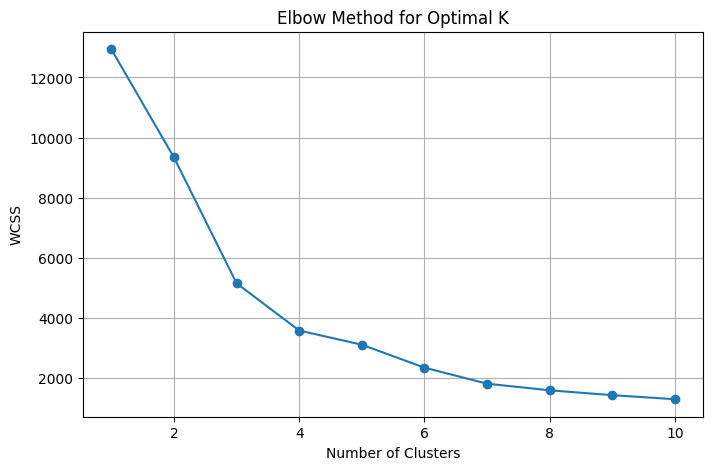

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


In [21]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,529,11,372.86,1
12347.0,367,2,1323.32,0
12348.0,438,1,222.16,0
12349.0,407,3,2671.14,0
12351.0,375,1,300.93,0


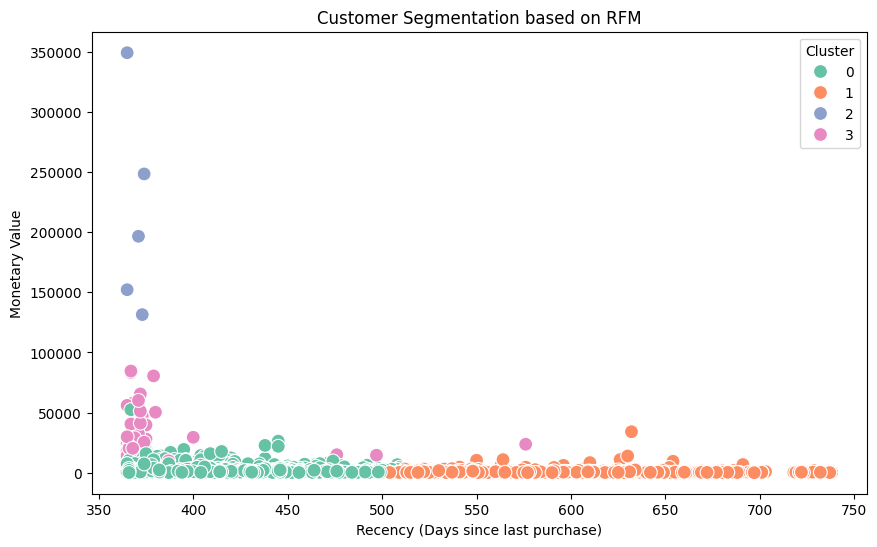

In [22]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title("Customer Segmentation based on RFM")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Monetary Value")
plt.show()


In [23]:
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,406.996882,4.469598,1743.129790
1,606.978988,1.659981,596.884493
2,369.600000,113.600000,215543.670000
3,379.433962,48.547170,29040.181566
